## Импорт библиотек для работы с байесовской нейросетью

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
# import idx2numpy
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
learning_rate = 0.001
num_epochs = 30
batch_size = 128
num_monte_carlo = 50
seed_start = 0
max_num_iter = 40

In [2]:
pwd

'D:\\git\\diplom\\bachelor-s-diploma'

In [3]:
from numpy.random import seed
seed(seed_start)
tf.random.set_seed(seed_start)

## Выделение видеопамяти на GPU

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Предобработка данных

In [5]:
IMAGE_SHAPE = [28, 28, 1]
NUM_TRAIN_EXAMPLES = 60000
NUM_HELDOUT_EXAMPLES = 10000
NUM_CLASSES = 10

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() ## x -картинки, y - метки, (60000,28,28)
x_train = x_train.reshape((60000,28,28,1))
x_train = x_train.astype('float32')/255
x_test = x_test.reshape((10000,28,28,1))
x_test = x_test.astype('float32')/255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
tfd = tfp.distributions

In [7]:
accuracy_epoch = []

In [8]:
M = 469
v = tf.Variable((2**(M-0))/((2**M)-1))

In [9]:
class CustomCallback(Callback):
    
    def on_train_batch_begin(self, batch,logs=None):
        v.assign((2**(M-batch))/((2**M)-1))
        kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p)*v /  tf.cast(num_epochs*NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        
        

In [18]:
class TestCallback(Callback):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def on_epoch_end(self, epoch, logs={}):
        x = self.x
        y = self.y
        prediction = Sampling(x)
        accuracy_epoch.append(accuracy_score(np.argmax(y,axis=1),np.argmax(prediction,axis=1)))

## Построение байесовской нейросети (архитектура LeNet-5)

In [19]:
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p)*v /  tf.cast(num_epochs * NUM_TRAIN_EXAMPLES, dtype=tf.float32))

In [20]:
model = tf.keras.Sequential([
tfp.layers.Convolution2DFlipout(6, kernel_size=5, padding='SAME',
                                kernel_divergence_fn=kl_divergence_function,
                                bias_divergence_fn = kl_divergence_function,
                                kernel_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                                bias_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                                kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                                    loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                                    untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                                ),
                                bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                                    is_singular=True,
                                    loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                                    untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                                ),
                                activation='relu', seed=seed_start, input_shape=(28,28,1)),
tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2],padding='SAME'),
tfp.layers.Convolution2DFlipout(16, kernel_size=5, padding='SAME',
                                kernel_divergence_fn=kl_divergence_function,
                                bias_divergence_fn = kl_divergence_function,
                                kernel_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                                bias_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                                kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                                    loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                                    untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                                ),
                                bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                                    is_singular=True,
                                    loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                                    untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                                ),
                                activation='relu', seed=seed_start),
tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2],padding='SAME'),
tfp.layers.Convolution2DFlipout(120, kernel_size=5, padding='SAME',
                                kernel_divergence_fn=kl_divergence_function,
                                bias_divergence_fn = kl_divergence_function,
                                kernel_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                                bias_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                                kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                                    loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                                    untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                                ),
                                bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                                    is_singular=True,
                                    loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                                    untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                                ),
                                activation='relu', seed=seed_start),
tf.keras.layers.Flatten(),
tfp.layers.DenseFlipout(84, kernel_divergence_fn=kl_divergence_function,
                        bias_divergence_fn = kl_divergence_function,
                        kernel_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                        bias_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                            loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                            untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                        ),
                        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                            is_singular=True,
                            loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                            untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                        ),
                        activation='relu', seed=seed_start),
tfp.layers.DenseFlipout(NUM_CLASSES, kernel_divergence_fn=kl_divergence_function,
                        kernel_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                        bias_posterior_tensor_fn=lambda d: d.sample(seed=seed_start),
                        bias_divergence_fn = kl_divergence_function,
                        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                            loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                            untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                        ),
                        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
                            is_singular=True,
                            loc_initializer=RandomNormal(stddev=0.1, seed=seed_start),
                            untransformed_scale_initializer=RandomNormal(mean=-3.0, stddev=0.1, seed=seed_start)
                        ),
                        activation='softmax', seed=seed_start)])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_3 (Conv2DFlip (None, 28, 28, 6)         306       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_flipout_4 (Conv2DFlip (None, 14, 14, 16)        4816      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_flipout_5 (Conv2DFlip (None, 7, 7, 120)         96120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5880)              0         
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 84)               

In [22]:
radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-2)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

In [23]:
model.compile(ranger, loss='categorical_crossentropy',metrics=['accuracy'])

## Обучаем нашу нейросеть

In [24]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,callbacks = [TestCallback(x_test, y_test)])

Epoch 1/30
469/469 [==============================] - 20s 35ms/step - loss: 1.9046 - accuracy: 0.6148
Epoch 2/30
469/469 [==============================] - 16s 35ms/step - loss: 0.8456 - accuracy: 0.9694
Epoch 3/30
469/469 [==============================] - 16s 35ms/step - loss: 0.7803 - accuracy: 0.9793
Epoch 4/30
469/469 [==============================] - 17s 35ms/step - loss: 0.7182 - accuracy: 0.9859
Epoch 5/30
469/469 [==============================] - 17s 35ms/step - loss: 0.6688 - accuracy: 0.9872
Epoch 6/30
469/469 [==============================] - 17s 36ms/step - loss: 0.6155 - accuracy: 0.98901s - ETA: 0s - loss: 0.6156 - accuracy
Epoch 7/30
469/469 [==============================] - 18s 38ms/step - loss: 0.5655 - accuracy: 0.9895
Epoch 8/30
469/469 [==============================] - 21s 45ms/step - loss: 0.5163 - accuracy: 0.9907
Epoch 9/30
469/469 [==============================] - 16s 35ms/step - loss: 0.4715 - accuracy: 0.9906
Epoch 10/30
469/469 [=======================

In [15]:
#test_loss,test_acc=model.evaluate(x_test,y_test)
#test_acc

313/313 [==============================] - 6s 12ms/step - loss: 0.1916 - accuracy: 0.9860


0.9860000014305115

In [16]:
# emnist_path = 'C:/Users/kamen/DIPLOM/'
# #X-test - буквы для теста, Y-test - метки букв
# X_test = idx2numpy.convert_from_file(emnist_path + 'emnist-letters-test-images-idx3-ubyte')
# Y_test = idx2numpy.convert_from_file(emnist_path + 'emnist-letters-test-labels-idx1-ubyte')
# X_test = X_test.reshape((20800,28,28,1))
# X_test = X_test.astype('float32')/255
# X_test=X_test[:10000,:,:,:]
# Y_test=to_categorical(Y_test)
# tf.shape(X_test)
# X_test = np.rot90(X_test,1,axes=(-2,-3))
# X_test=X_test[:,:,::-1,:]
# validation_set=np.concatenate([X_test,x_test])


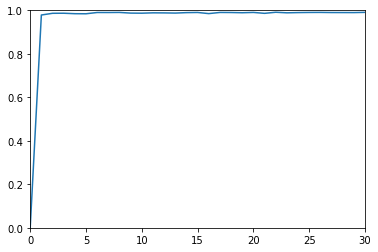

In [29]:
#k = np.zeros(1)
#accuracy_epoch = np.array(accuracy_epoch)
#accuracy_epoch = np.concatenate((k,accuracy_epoch))

plt.plot(accuracy_epoch)
plt.ylim(0,1)
plt.xlim(0,30)
plt.show()
np.savetxt("bayesian_acc.txt",accuracy_epoch)

In [16]:
prediction = Sampling(x_test)
res_of_pred = accuracy_score(np.argmax(y_test,axis=1),np.argmax(prediction,axis=1))

In [17]:
res_of_pred

0.9901

## Функция сэмплирования N раз полученных массивов вероятностей

In [11]:
 def Sampling(test_set):
    #print(' ... Running monte carlo inference')
    probs = tf.stack([model.predict(test_set)
        for _ in range(num_monte_carlo)],axis=0)
    mean_probs = tf.reduce_mean(probs, axis=0)
    return mean_probs


# Начало лишних в данный момент функций (определение порога распознавания - в данный момент лишние и закоменчены)

In [18]:
# mean_probability=Sampling(validation_set)

In [19]:
# Predict_set_letters_label = np.zeros(len(validation_set))#Поиск порога отказа
# Predict_set_letters_prob = np.zeros(len(validation_set))
# for i in range(len(validation_set)):
#     Predict_set_letters_label[i] = np.argmax(mean_probability[i,:])
#     Predict_set_letters_prob[i]=np.max(mean_probability[i,:])

In [20]:
# failure_threshold=tf.reduce_mean(Predict_set_letters_prob,axis=0)
# failure_threshold=tf.reshape(failure_threshold,[]).numpy()

In [21]:
# print(failure_threshold,"Порог минимальной вероятности")

In [22]:
# def Predict_a_picture(picture_to_predict):
#     array_probability = Sampling(picture_to_predict)
#     probability = np.max(array_probability)
#     label = np.argmax(array_probability)  
#     if (probability<failure_threshold):
#         print("This is not a digit")
#     else:
#         print("Это цифра",labels,"с вероятностью",probability)
#     return 1
    

# Конец лишних функций - далее работаем с текущей задачей

### Функция построения состязательной атаки для конкретной картинки при помощи FGSM метода

In [23]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image):
    predict_array = Sampling(input_image)
    number_index =np.argmax(predict_array)
    input_image=tf.convert_to_tensor(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        label = tf.one_hot(number_index,predict_array.shape[-1])
        label = tf.reshape(label, (1, predict_array.shape[-1]))
        loss = loss_object(label, prediction) + sum(model.losses)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    signed_grad = signed_grad.numpy()
    return signed_grad

## Построение гистограммы вероятностей + изображение под действием состязательной атаки

In [24]:
def build_adv_final(img):
    indices= list(range(0,10))
    attack = create_adversarial_pattern(img)
    for i in range(25):
        data_array = Sampling(np.clip(img+0.01*i*attack,a_max = 1.,a_min = 0.))[0]
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
        axes[0].bar(indices,data_array)
        axes[0].set_title('Атака FGSM - методом, eps =%s '%(0.01*(i)))
        axes[0].set_xlabel('Метка класса')
        axes[0].set_ylabel('Вероятность')
        axes[0].set_ylim(0,1.0)
        image = np.clip(img[0,:,:,:]+0.01*i*attack[0,:,:,:],a_max = 1., a_min =0.)
        image = tf.clip_by_value(image, -1, 1)
        axes[1].imshow(image,cmap='gray')
        plt.show()
        print(np.max(data_array))

In [25]:

# test_pic = x_test[159,:,:,:]
# test_pic = test_pic.reshape((1,28,28,1))
# build_adv_final(test_pic)

In [26]:
x_test1 = x_test.reshape(10000,1,28,28,1)

In [27]:
noise_array = np.zeros((10000,1,28,28,1))

In [28]:
# %%time

# for i in range(10000):
#     if (i%10 == 0):
#         print(i)
#     noise_array[i,:,:,:,:] = create_adversarial_pattern(x_test1[i,:,:,:])
# noise_array = noise_array.reshape((10000,28*28))
# np.savetxt(f"bayesian_noise_array_{seed_start}.txt",noise_array)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [29]:
# noise_array = noise_array.reshape((10000,28,28,1))
# x_test1 = x_test1.reshape((10000,28,28,1))

In [30]:
# %%time
# res_of_pred = np.zeros(max_num_iter)
# for i in range(max_num_iter):
#     print(i)
#     prediction = Sampling(x_test1+0.01*i*noise_array)
#     res_of_pred[i] = accuracy_score(np.argmax(y_test,axis=1),np.argmax(prediction,axis=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Wall time: 48min 50s


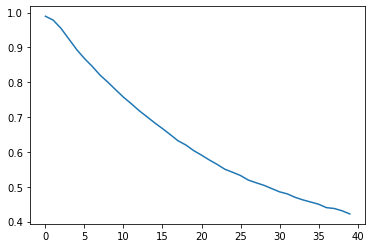

In [31]:
# plt.plot(res_of_pred)
# plt.show()

In [32]:
# np.savetxt(f"bayesian_results_{seed_start}.txt",res_of_pred)

In [33]:
# bayes = np.loadtxt("bayesian_results_3107.txt")
# default = np.loadtxt("default_results_78.txt")

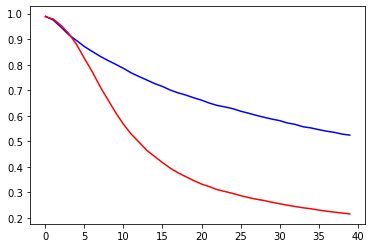

In [34]:
# plt.plot(bayes,color = 'b')
# plt.plot(default,color = 'r')
# plt.show()

## 